In [179]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [180]:
"""Constants"""
eps0 = 8.854e-12 #Vacuum permittivity[F/m]
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]
kb = 1.38064852e-23 #Boltzmann constant

In [181]:
"""Material dependant constants:"""
'''Fluid'''
fluid_density = 0.164 #helium
atm = 4.002602 * 1.6605402e-27 #helium atomic mass
eta = 1.96e-5 #shear viscosity
beta = 0 #bulk viscoisty
eps_rel = 1 #relative permittivity
eps = eps0 * eps_rel #permittivity of fluid
k = 1/(4*math.pi*eps)
lp = 17.5e-3 #mean free path * pressure
pressure = 101.325e3
temp = 298.15
A1 = 1.277 #experimentally determined constant used in Cunningham correction factor

'''QDs'''
#(InAs/GaAs QDs)
Rt = (10*h)/(e**2) #tunneling resistance (arbritary value)
m_eeff = 0.067 * m_e #electron effective mass [kg]
m_heff = 0.34 * m_e #hole effective mass [kg]
E_g = 0.36 * 1.60217662e-19 #band gap of QD (InAs bulk) [J]


'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
R_c = 1 #capacitor circuit resistance (arbritary value)

In [182]:
"""Initial parameter functions"""
def seperation_angle(n):
    """angle between each quantum dot"""
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    """motor radius"""
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    """length of rotor arm"""
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    """width of rotor arm"""
    w = ( Rp*math.sin(PHI) )/2
    return w

def inertia(rho, thc, r, w, Rp, p):
    """Calculates inertia of inner rotating section (rotor)"""
    m_cog = rho*thc*w*r
    m_disc = math.pi * ((Rp-r)**2)*thc*rho
    I = m_cog*((r**2) + (w**2)) + p*m_cog*((Rp-(r/2))**2) + m_disc*((Rp-r)**2)
    return I

In [183]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (r/2) * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, n, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e #number of holes stored in quantum dot
        elif i in range(3, n, 4):
            q_ch = -noc*e #number of holes stored in quantum dot
        else:
            q_ch = 0 #neutral quantum dots
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [184]:
"""Friction coefficient calculator functions"""

def C(eta0, sigma, Cc):
    """Calculates frictional coefficient of spheres used to model rotor arm, adjusted by Cunningham correction factor"""
    coef = (6*math.pi*eta0*sigma)/Cc #Stokes drag divided by Cunningham correction
    return coef

def Cunningham_correction(A1, lp, pressure, temp, R):
    """Calculates the Cunningham correction factor"""
    l = (lp * temp)/(273.15 * pressure) #mean free path
    Kn = l/R #Knudsen number
    Cc = 1 + (A1 * Kn) #only valid for Kn<0.4
    return Cc    

def  f_t(C, eta0, N, s):
    """Calculates scalar frictional coefficient"""
    f = 1/( (1/(N*C)) + ( s/(6*math.pi*(N**2)*eta0) ) )
    return f

def average_inverse_sum( position, N):
    """Determines inverse sum used in calculating f_t"""
    i = 0
    j = 0
    s = 0
    for i in range(N):
        for j in range(N):
            if ( i == j ):
                s += 0
            else:
                r = r_ij(i, j, position)
                s += 1/r
    return s

def positions(Nx, Ny, sigma):
    """Postions of spheres"""
    position = {}
    i = 0
    j = 0
    m = 0
    for j in range(Ny):
        for i in range(Nx):
            x = sigma + 2 * i  * sigma
            y = sigma + 2 * j * sigma
            position.update({m:[x,y]})
            m += 1
    return position

def r_ij(i, j, position):
    """Distance between spheres"""
    distance = math.sqrt( ((position[i][0]-position[j][0])**2) + ((position[i][1]-position[j][1])**2) )
    return distance

def friction_function(eta, thc, width, Cc):
    """Calculates scalar frictional coefficient of one arm"""
    m = 10 #how many times calculation iterates, higher m = higher precision and accuracy but takes longer
    sigma = 5e-9 #starting radius of spheres
    sigmax = sigma/(m+2) #used to store smaller radius of spheres 
    Nx = int(width/(2*sigmax)) #number of spheres in the 'x' direction
    Ny = int(thc/(2*sigmax)) #number of spheres in the 'y' direction
    N = Nx * Ny #total number of spheres
    const = C(eta, sigmax, Cc)
    coord = positions(Nx, Ny, sigmax) #determines the positions of the centers of the spheres
    s = average_inverse_sum(coord, N)
    friction = f_t(const, eta, N, s)
    return (friction) #returns scalar frictional coefficient

In [185]:
"""Active motor functions: torque"""

def tangential_component(k , n, e, R, Rp, gamma, noc, width, r):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge edge
        ric = math.sqrt(  ( (Rp-(r/4) )**2) + (R**2) - 2*(Rp-(r/4))*R*math.cos(QDs[i][2]-gamma) ) #distance between QD and permanent charge center
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        '''Alpha is alpha at edge of permanent charge'''
        if ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) > 1 or ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha        
        '''Alphac is alpha at center of permanent charge'''
        if ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) > 1 or ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) < -1 : #accounts for computational error
            alphac = 0
        else:
            alphac = math.acos((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) #angle to tangential in which torque vector acts
        if i > n/2:
            alphac = -alphac
        '''boundaries of the capacitor arm'''
        ex_minus = ri*math.sin(alpha) - (width/2) 
        ex_plus = ri*math.sin(alpha) + (width/2)
        ey_minus = ri*math.cos(alpha)
        ey_plus = ri*math.cos(alpha) + (r/2)
        sigma = PCs[0][3]/(width*r)
        f = force(ex_minus, ex_plus, ey_minus, ey_plus)
        F_c = k*sigma*Q[3]*f #coulomb force between permanent charge and QD
        F_t += F_c*math.sin(alphac) #determines tangential component
    return F_t

def force( c1, c2, c3, c4):
    """Part of Coulomb force calculation, taking into account the charge distribution of the capacitor arms"""
    a1 = (c4 + math.sqrt((c4**2)+(c1**2)))*(c3 + math.sqrt((c3**2)+(c2**2)))
    b1 = (c4 + math.sqrt((c4**2)+(c2**2)))*(c3 + math.sqrt((c3**2)+(c1**2)))
    a2 = (c2 + math.sqrt((c2**2)+(c3**2)))*(c1 + math.sqrt((c1**2)+(c4**2)))
    b2 = (c2 + math.sqrt((c2**2)+(c4**2)))*(c1 + math.sqrt((c1**2)+(c3**2)))
    I1 = math.log(a1/b1)
    I2 = math.log(a2/b2)
    f = math.sqrt( (I1**2) + (I2**2) )
    return f

def torque (F_t, Rp, p, r):
    """Computes torque on enitre inner rotor"""
    torque_radius = Rp - r/4
    torque = F_t * torque_radius * p
    return torque

In [186]:
"""Active motor functions: energy"""

def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots(n,e, noc) #calls function to initialize QDs
    voltage = ( QDs[0][3]/(2*Cdot) ) #voltage needed to add one electron
    return voltage

def QD_capacitance( eps, d):
    """Capacitance of single quantum dot"""
    Cdot = 2*math.pi*eps*d
    return Cdot

def Capacitor_charging_time( R, C):
    "Computes charging time for capacitors"
    tc = 4 * R * C
    return tc

def Dot_charging_time( Rt, Cdot):
    "Computes charging/discharging time for QDs"
    td = Rt * Cdot
    return td

def Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c):
    """Input power for each step"""
    #for capacitor charging
    E_cC = (PCs[0][3] * cap_vol)
    #for -ve charged dots, energy corresponds to that needed to the required voltage to cause electrons to tunnel into the dot
    E_cQD = (Charging_voltage_QD( n, e, Cdot) * noc * e )
    #for +ve charged dots, energy corresponds to laser energy plus voltage emergy to make electrons tunnel out of the dot
    #laser energy depends on bandgap/energy level seperation
    if (noc % 2 == 0):
        J = noc/2
    else:
        J = (noc + 1)/2
    
    E_l = E_g + ((h**2)*J/(8*m_eeff*(diam**2))) + ((h**2)*J/(8*m_heff*(diam**2)))
    E_intotal = (E_cQD * n) + ( (n/2) * (E_l + E_cC) )
    return E_intotal

def Output_power(angv, torque):
    """Power output by the motor"""
    return angv * torque

def efficiency(E_in, E_out):
    """Efficiency of motor"""
    eff = (E_out/E_in)
    return eff

In [187]:
"""Mathematical functions"""

def func(x, A, B, C, D, E, F, G, H, J, K, L, M, O, P, S, U):
    """Used to approximate torque function"""
    return A*(x**15) +B*(x**14)+ C* (x**13)+ D*(x**12)+ E*(x**11) + F*(x**10) + G* (x**9) + H * (x**8) + J * (x**7) + K * (x**6) + L * (x**5)+ M * (x**4) + O * (x**3) + P * (x**2) + S * x + U

def solvr( Y, t, params):
    """Used in ODE solver"""
    const, A, B, C, D, E, F, G, H, J, K, L, M, O, P, S, U = params
    return [ Y[1], ( A *(Y[0]**15) + B*(Y[0]**14) + C*(Y[0]**13) + D*(Y[0]**12) + E*(Y[0]**11) + F*(Y[0]**10) + G * (Y[0]**9) + H * (Y[0]**8) + J * (Y[0]**7) + K * (Y[0]**6) + L * (Y[0]**5) + M * (Y[0]**4) + O * (Y[0]**3) + P*(Y[0]**2) + S*Y[0]+ U - const * Y[1]) ]

In [188]:
"""Brownian motion functions"""
def volume( Rp, r, w, thc, p): #volume of segment
    V = ( ((math.pi*( (Rp**2) - ((Rp-r)**2) ))/p) - r*w ) * thc
    return V

def mass( volume, density): #mass of fluid in segment
    M = volume * density
    return M

def number(mass, atm): #number of fluid particles in segment
    N = mass/atm
    return N

def sd( kb, temp, particle_mass, no_of_particles, time_step, p):
    sigma = math.sqrt((p*kb*temp*particle_mass*(no_of_particles**2)*(time_step**2)*(3*math.pi - 8))/(4*math.pi)) * (0.5 - (4/(math.pi**2)))
    return sigma

def vp( kb, temp, particle_mass):
    v = math.sqrt((2*kb*temp)/particle_mass)
    return v

def rand_fb(kb, temp, particle_mass, no_of_particles, time_step, p):
    mu = 0
    sigma = sd( kb, temp, particle_mass, no_of_particles, time_step, p)
    boundary = 3*sigma
    rfb = random.uniform(mu - boundary, mu + boundary)
    return rfb

def rand_ffb(kb, temp, particle_mass, no_of_particles, time_step, fb, p):
    sigma = sd( kb, temp, particle_mass, no_of_particles, time_step, p)
    rffb_max = (1**2)/(math.sqrt(2*math.pi*(sigma**2)))
    rffb = random.uniform( 0, rffb_max)
    return rffb

def prob_dist_fb(kb, temp, particle_mass, no_of_particles, time_step, fb, p):
    mu = 0
    sigma = sd( kb, temp, particle_mass, no_of_particles, time_step, p)
    ffb = (1**2)/(math.sqrt(2*math.pi*(sigma**2))) * math.exp( -((fb-mu)**2)/(2*(sigma**2)) )
    return ffb

In [189]:
"""Initial parameters:"""
'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
n = 80   #number of QDs [no unit]
PHI = seperation_angle(n) #angle of seperation between QDs
R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
p = int(n/2)   #number of permanent charges (PCs) [no unit]
r0 = 110e-9 #distance between outer QD ring and edge of capacitor arms
Rp = R - r0   #radius of rotating disc [m]
w = width( Rp, PHI )#cog "tooth"/capacitor arm width [m]
r = cog_length( Rp, PHI)    #length of the cog shaft [m]
thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 2   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
I = inertia(rho, thc, r, w, Rp, p) #inertia of inner rotating disk

'''Medium'''
Cc = Cunningham_correction(A1, lp, pressure, temp, R)
cof = friction_function(eta, thc, w, Cc)
constant =  p * cof  #coefficient of drag force function
vol = volume( Rp, r, w, thc, p) #volume in one segment
M = mass( vol, fluid_density) #mass of fluid in one segment
no = number(M, atm) #number of particles in one segment

vav = vp( kb, temp, atm) #most probable speed of particles in segment
tStep_max = 2 * Rp/(p * vav) #maximum time step Brownian motion approximation is valid for
print (tStep_max)

7.515990332410941e-11


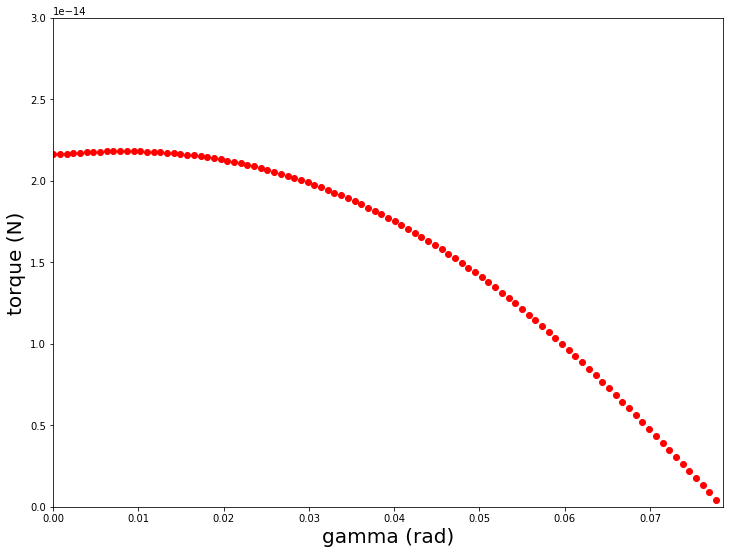

In [190]:
"""Main function"""
step = seperation_angle(n) #angle between each QD, angle required for one step
angle_increment = step/100 #angle to be incremented when producing torque function 
PCs = permanent_charges( Rp, p , cap_d, cap_vol, w, r) #initializes permanent charges

"""Graph of torque function to be approximated"""
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('gamma (rad)', fontsize = '20')
ax1.set_ylabel('torque (N)', fontsize = '20')
ax1.set_xlim( 0 , step )
ax1.set_ylim( 0 , 3e-14)

"""Computation of 'true' torque """
i = 0
T = []
gamma_list = []
for gamma in np.arange(0, step, angle_increment): #iterates angle increment until one step is completed
    gamma_list.append( gamma ) #list storing values of the angle
    F_t = tangential_component(k , n, e, R, Rp, gamma, noc, w, r) #determines tangential component of Coulomb force
    T.append( torque(F_t, Rp, p, r) ) #calculates torque acting on inner rotor
    ax1.scatter(gamma, T[i] , color = 'r') #plots torque vs angle rotated
    i += 1 #needed to keep track of T array

plt.show()

In [191]:
"""Scaling to make approxiamtion more accurate"""
for i in np.arange( 0, int(step/angle_increment) ):
    T[i] = T[i] * 1e14

C:\Users\Pauli\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Pauli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


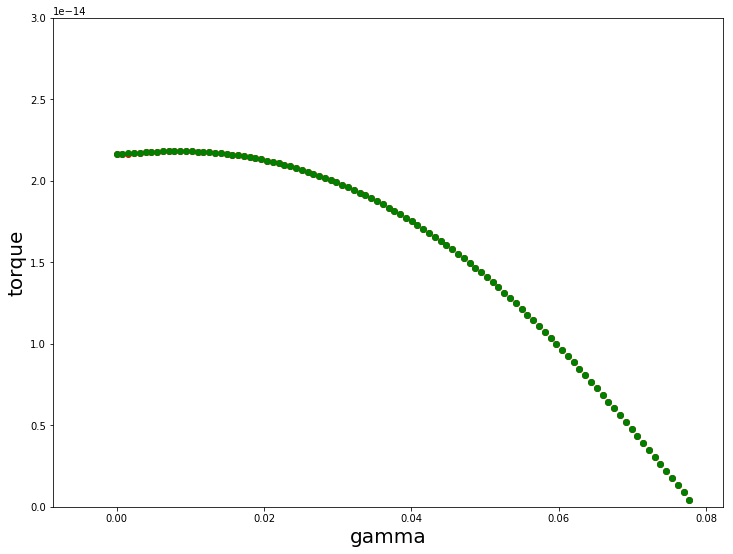

In [192]:
"""Approximate torque function"""
popt, pcov = curve_fit(func, gamma_list, T) #fits curve to previously calculated torque using func
'''Output constants'''
A = popt[0] * 1e-14
B = popt[1] * 1e-14
C = popt[2] * 1e-14
D = popt[3] * 1e-14
E = popt[4] * 1e-14
F = popt[5] * 1e-14
G = popt[6] * 1e-14
H = popt[7] * 1e-14
J = popt[8] * 1e-14
K = popt[9] * 1e-14
L = popt[10] * 1e-14
M = popt[11] * 1e-14
O = popt[12] * 1e-14
P = popt[13] * 1e-14
S = popt[14] * 1e-14
U = popt[15] * 1e-14

"""Rescaling"""
for i in np.arange( 0, int(step/angle_increment) ):
    T[i] = T[i] * 1e-14

'''Plots original torque function and fitted torque function on same graph'''
fig2 = plt.figure(figsize=(12, 9))
bx1 = fig2.add_subplot(111)
bx2 = fig2.add_subplot(111)
bx1.set_xlabel('gamma', fontsize = '20')
bx1.set_ylabel('torque', fontsize = '20')
bx1.set_ylim( 0 , 3e-14)
for i in np.arange( 0, int(step/angle_increment) ):
    bx1.scatter( gamma_list[i], T[i], color = 'r' )
    bx2.scatter( gamma_list[i], ( func(gamma_list[i], A, B, C, D, E, F, G, H, J, K, L, M, O, P, S, U) ), color= 'g' )
plt.show()

In [195]:
"""Solve ODE for motor with viscous drag and Brownian force"""
tStop = 1e-2
tInc = 1e-6
t_array = np.arange( 0, tStop, tInc)
initial_sol = [0, 0]
complete_sol = np.zeros((len(t_array),2))
i = 0
for time in np.arange(0, tStop, 2*tInc):
    fb_t = 0
    for dt in np.arange(0, tInc, tStep_max):
        accepted = 0
        while(accepted == 0):
            fb = rand_fb(kb, temp, atm, no, tStep_max, p)
            ffb = prob_dist_fb(kb, temp, atm, no, tStep_max, fb, p) #probability of fb
            rffb = rand_ffb(kb, temp, atm, no, tStep_max, fb, p) #random number between 0 and peak probability
            if (rffb <= ffb): #if random number <= probability of fb, than accept fb
                accepted = 1
        fb_t += fb
    print(fb_t)
    Utemp = U + fb_t
    params = [ (constant*((Rp-(r/4))/2))/I , A/I, B/I, C/I, D/I, E/I, F/I, G/I, H/I, J/I, K/I, L/I, M/I, O/I, P/I, S/I, Utemp/I ]
    sol = odeint( solvr, [initial_sol[0], initial_sol[1]], [ t_array[i], t_array[i+1] ], args=(params,) )
    initial_sol[0] = sol[1][0]
    initial_sol[1] = sol[1][1]
    complete_sol[i][0] = sol[0][0]
    complete_sol[i][1] = sol[0][1]
    complete_sol[i+1][0] = sol[1][0]
    complete_sol[i+1][1] = sol[1][1]
    print(t_array[i])
    i += 2

-7.06815463025447e-28
0.0
-1.4775780863589918e-27
2e-06
2.321193054337917e-28
4e-06
3.1373039680995396e-28
6e-06
7.473326897486255e-29
8e-06
-8.677455618009793e-28
1e-05
-8.387126752723218e-28
1.2e-05
-5.8055737589661675e-28
1.4e-05
1.1514968470330263e-27
1.6e-05
-3.536082096872792e-28
1.8e-05
5.8998422747674805e-28
2e-05
-1.711671038845905e-27
2.2e-05
4.737591454532449e-28
2.4e-05
6.073364856411782e-29
2.6e-05
-6.792686390355123e-29
2.8e-05
3.664904116701248e-28
3e-05
-5.871448009113506e-28
3.2e-05
-9.589774903857241e-28
3.4e-05
-6.39864847000955e-28
3.6e-05
2.2139991960131151e-29
3.8e-05
-3.2400287349019254e-29
4e-05
-4.509625326942256e-29
4.2e-05
6.736238063508409e-29
4.4e-05
1.1893117894814537e-27
4.6e-05
1.2534812214905046e-28
4.8e-05
-2.9167754756801195e-28
5e-05
-3.4506421233873913e-28
5.2e-05
-3.1839483153384273e-29
5.4e-05
1.0264542451547156e-28
5.6e-05
-1.856296015182501e-28
5.8e-05
-1.2013492574621468e-27
6e-05
1.4214412191936538e-28
6.2e-05
5.997823309532244e-28
6.4e-05
1.7

-9.297635797216354e-28
0.000524
-2.1373625271271116e-29
0.000526
5.201000058339953e-28
0.000528
2.574966062685774e-28
0.00053
5.982269279586801e-29
0.000532
-2.6556991441894127e-28
0.000534
-5.306887705294339e-28
0.000536
-4.577639152059266e-28
0.000538
-1.0107139284099313e-27
0.00054
-4.075199467774734e-28
0.000542
8.958284875455415e-28
0.000544
-2.456479174329801e-28
0.000546
-1.2641737235020729e-27
0.000548
-3.8316640726219404e-28
0.00055
2.476407132016452e-28
0.000552
7.360638590300034e-28
0.000554
2.5326744164349334e-28
0.000556
-3.649417375441194e-28
0.000558
-4.566465894027813e-28
0.00056
-1.6227926521845438e-27
0.000562
4.734633683906366e-28
0.000564
1.0675309086224174e-27
0.000566
-3.220976221890937e-28
0.000568
-5.698844262368039e-28
0.00057
3.4298366289063234e-28
0.000572
1.6237483183290338e-28
0.000574
-4.410232870147387e-28
0.000576
2.8190982487586364e-28
0.000578
6.032211184202165e-28
0.00058
4.097335368310606e-28
0.000582
-3.13724210669321e-28
0.000584
3.1967456863945436

C:\Users\Pauli\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1.0003835615810878e-27
0.000806
-1.1008496513373303e-27
0.000808
4.720144104980795e-28
0.00081
-5.414019702567455e-28
0.000812
6.330638818510282e-28
0.000814
7.558723353704857e-28
0.000816
7.952553287668054e-28
0.000818
6.951140626487669e-28
0.00082
1.367441314360763e-28
0.000822
1.3199114886628406e-28
0.000824
-4.8837437328497075e-29
0.000826
-1.8885057383696233e-29
0.000828
-3.181728930022812e-28
0.00083
-2.350027524851476e-28
0.000832
6.1318041164670735e-28
0.000834
4.107695882911992e-28
0.000836
1.424709636813919e-27
0.000838
9.35128770952485e-28
0.00084
-1.9928508472362926e-29
0.000842
-2.5979001884753777e-28
0.000844
6.7566860493124175e-28
0.000846
1.0292155106735508e-27
0.000848
-7.614744193414774e-28
0.00085
2.2640126715533734e-28
0.000852
1.1019419163027786e-27
0.000854
3.927055373742324e-28
0.000856
-1.1550388387205968e-28
0.000858
4.29028264097897e-28
0.00086
7.57538106244022e-28
0.000862
8.96733788797988e-28
0.000864
7.686847270454676e-28
0.000866
8.481738453689242e-28
0.00

-2.0715443773647425e-28
0.001324
-1.2684703488660004e-27
0.001326
2.2226329347414173e-28
0.001328
8.899501470964077e-28
0.00133
5.791249956256859e-28
0.001332
-4.435413952319681e-28
0.001334
4.730050077877776e-28
0.001336
1.1583747359876868e-27
0.001338
5.362053645330522e-28
0.00134
-5.675273438853143e-28
0.001342
-1.3368546405494284e-27
0.001344
-4.438264958462876e-28
0.001346
5.0062735202192034e-29
0.001348
1.1896702678175039e-27
0.00135
3.103010377644246e-28
0.001352
1.2785314276664739e-27
0.001354
-7.532345704627007e-28
0.001356
-2.383862519152882e-28
0.001358
2.558865815638515e-28
0.00136
9.869040463107887e-29
0.001362
7.984474520518922e-29
0.001364
-4.297422238977859e-28
0.001366
2.336260483608607e-28
0.001368
1.4281414479862277e-28
0.00137
1.2189058490042179e-27
0.001372
1.2672922674417134e-27
0.001374
5.67862396040212e-28
0.001376
5.151219390314415e-28
0.001378
8.51890788118711e-28
0.00138
4.27468310568923e-28
0.001382
5.538194260110428e-28
0.001384
5.268124992604509e-28
0.0013

4.66403295354395e-28
0.001844
1.800832226034812e-28
0.001846
-1.1838099184572732e-27
0.001848
-3.7138532449002955e-28
0.00185
-1.2862371477777537e-28
0.001852
-2.4236310408670625e-28
0.001854
-4.750696711451581e-28
0.001856
-5.47690971562455e-29
0.001858
9.330891873059299e-29
0.00186
4.628430763135544e-29
0.001862
3.4332860238389487e-28
0.001864
-3.645961651802082e-29
0.001866
-4.89875697306003e-28
0.001868
-3.3915194470808384e-28
0.00187
7.541498610888374e-28
0.001872
4.597206395315479e-28
0.001874
-1.852909997825323e-28
0.001876
4.615171696850024e-29
0.001878
-2.5299534818305953e-28
0.00188
3.0954870168959016e-28
0.001882
-1.3784751643798479e-27
0.001884
-1.1887456339244204e-27
0.001886
1.9365848835219723e-28
0.001888
-4.187560082194091e-28
0.00189
2.004229095922449e-28
0.001892
1.9332719051830028e-27
0.001894
7.259959789093172e-28
0.001896
-5.633240941482221e-28
0.001898
-9.613031681830037e-29
0.0019
9.185629261719408e-28
0.001902
-3.1129028252834873e-28
0.001904
2.4634517174548095e

-7.988790901250544e-28
0.002364
-7.725186786793895e-28
0.002366
7.702298765331272e-28
0.002368
-1.6395134211566225e-27
0.00237
8.07344673434555e-28
0.002372
-2.875066978453939e-29
0.002374
2.524764668464268e-28
0.002376
1.5224560698804532e-27
0.002378
5.1890222000186635e-28
0.00238
3.5976037894695634e-28
0.002382
5.744451139089958e-28
0.002384
9.420678854451101e-28
0.002386
7.182615225070659e-28
0.002388
-6.315250260838835e-28
0.00239
-3.7290007429207414e-28
0.002392
-1.3682345117140025e-27
0.002394
-4.161918650771575e-28
0.002396
9.50896447885982e-28
0.002398
-5.126233305980619e-28
0.0024
-7.780727245158761e-28
0.002402
-1.938489933133013e-27
0.002404
8.595141272470001e-29
0.002406
-2.6508343093913725e-28
0.002408
1.6955753544625822e-28
0.00241
-3.451722638843537e-28
0.002412
-6.766513661977172e-28
0.002414
1.1987412697650247e-27
0.002416
-6.409356156008188e-29
0.002418
9.942044055012038e-28
0.00242
9.424795947801623e-28
0.002422
6.915154881811032e-28
0.002424
9.030273779188005e-28
0.

-4.601284226815052e-28
0.002886
2.0233764688079564e-27
0.002888
1.4704704051115759e-27
0.00289
6.135887273371377e-28
0.002892
-6.791509213887065e-28
0.002894
-2.465982495510041e-28
0.002896
6.1237867338388195e-28
0.002898
8.607502713179284e-29
0.0029
5.202890679230071e-28
0.002902
1.2387287344174124e-27
0.002904
1.165742940594851e-27
0.002906
2.0640506487195405e-28
0.002908
4.3693650647419344e-28
0.00291
-1.2433718389824911e-27
0.002912
-2.6500390222455582e-28
0.002914
-1.239811804697478e-27
0.002916
-1.0343309388625423e-27
0.002918
-5.431908012172414e-28
0.00292
1.0130857238838541e-27
0.002922
1.2085423431285335e-27
0.002924
1.4190911517584106e-27
0.002926
1.762241684734606e-28
0.002928
3.379518478059481e-28
0.00293
7.911759339128218e-28
0.002932
5.4455545772235805e-28
0.002934
-5.062514007127819e-28
0.002936
-2.4335357444757066e-28
0.002938
7.765705240861895e-28
0.00294
2.4380045823979574e-29
0.002942
3.840368187571106e-28
0.002944
3.1392844332999214e-28
0.002946
1.3225252835613396e-

-1.2645555950279203e-27
0.003406
7.380220411247323e-28
0.003408
-3.475394018150115e-28
0.00341
-2.121242449525317e-28
0.003412
-2.03977039411676e-30
0.003414
9.616415627460468e-28
0.003416
7.098512304308792e-28
0.003418
-2.38020469797393e-28
0.00342
-1.0295148670320978e-27
0.003422
1.3560783845632333e-27
0.003424
-6.102219986303449e-28
0.003426
1.292013288825265e-27
0.003428
-1.0209541607709797e-27
0.00343
-4.263192796807906e-28
0.003432
-6.316835345648352e-28
0.003434
7.9246473939997715e-28
0.003436
-7.446894504324436e-29
0.003438
5.559457053374513e-28
0.00344
-5.346391111897889e-28
0.003442
2.49236813665624e-28
0.003444
2.774656700844522e-28
0.003446
-6.185722901993878e-28
0.003448
-8.213498387274295e-28
0.00345
-4.0480087534796375e-28
0.003452
-1.812012025001701e-28
0.003454
-4.726785899062605e-28
0.003456
-1.895536795346198e-27
0.003458
-1.727775853970782e-27
0.00346
-1.1692129840041965e-27
0.003462
-1.6181677750124172e-28
0.003464
4.158950971165409e-29
0.003466
-8.234168375593256e

2.2506065052166736e-28
0.003924
-4.346809814836984e-28
0.003926
4.5099395697648445e-28
0.003928
3.7169951804483846e-28
0.00393
9.886478894482384e-28
0.003932
2.200042496227354e-28
0.003934
-3.609833549234574e-28
0.003936
-6.527905996959035e-28
0.003938
6.134334647248723e-28
0.00394
-6.578265893825009e-28
0.003942
-5.715066542668154e-28
0.003944
-1.4325936191603608e-29
0.003946
6.940941029566203e-28
0.003948
1.102920365749315e-27
0.00395
4.728742143884156e-28
0.003952
-1.6545660671934542e-27
0.003954
-2.5019248431873963e-28
0.003956
1.2060355848755228e-27
0.003958
1.5306348934370738e-27
0.00396
-8.785086714330854e-28
0.003962
-5.630546677142237e-28
0.003964
-2.2269023540160586e-28
0.003966
-7.084352303812158e-28
0.003968
3.8162823779283868e-28
0.00397
9.517497326484505e-28
0.003972
1.5116104690413083e-28
0.003974
-7.372825671027296e-28
0.003976
-1.5290919237827845e-28
0.003978
1.7067649390900814e-27
0.00398
7.495989715723955e-29
0.003982
2.52273660649253e-28
0.003984
7.3358253456459765e

4.543838199663374e-28
0.004444
9.993460275869215e-28
0.004446
9.5033164176966e-28
0.004448
-5.537123047456349e-28
0.00445
-1.7872106218882412e-28
0.004452
8.478700190130065e-28
0.004454
-1.8678795865231302e-30
0.004456
3.2060448941917954e-28
0.004458
3.367389489089918e-28
0.00446
-9.440329160311367e-29
0.004462
-2.626535419075771e-28
0.004464
7.862976618580803e-28
0.004466
1.470699577971941e-28
0.004468
-7.0754508934152005e-28
0.00447
1.0056559450808585e-27
0.004472
4.988737653693338e-28
0.004474
-7.581279663606134e-28
0.004476
-3.9875623157419843e-28
0.004478
-4.0328355081354974e-28
0.00448
-1.0452562578858676e-27
0.004482
4.560567266022501e-28
0.004484
-1.0919837887498197e-27
0.004486
-1.2339603278414756e-28
0.004488
1.0211895958354115e-27
0.00449
2.023979824909173e-27
0.004492
-7.569188847728778e-28
0.004494
9.039517018032819e-28
0.004496
-1.3412063714690056e-28
0.004498
5.876465117657969e-28
0.0045
5.763186604905306e-28
0.004502
-1.0680818955057208e-28
0.004504
1.0186274347212621e-

-1.9930965110957367e-29
0.004964
-5.85043882519097e-28
0.004966
-1.0374230757752074e-27
0.004968
-8.25488626846058e-28
0.00497
-1.5283678604557677e-27
0.004972
-5.599280794558361e-28
0.004974
-4.376651722941206e-30
0.004976
-1.3095109850090807e-27
0.004978
6.442464270029097e-28
0.00498
-3.024634036135816e-28
0.004982
4.527384739305235e-28
0.004984
-2.475983691290262e-28
0.004986
-2.0123763674002107e-28
0.004988
-1.1370091275894079e-27
0.00499
-1.5354766914249595e-27
0.004992
-1.8259003242357926e-28
0.004994
-4.64437021607056e-28
0.004996
-1.177812089246374e-28
0.004998
3.8783039855839243e-28
0.005
3.1891809369641338e-28
0.005002
3.9815613914929284e-28
0.005004
2.7106716640246505e-28
0.005006
1.112531475679436e-27
0.005008
-1.0720344443075798e-28
0.00501
-4.760841856129309e-28
0.005012
-7.601230056601181e-29
0.005014
1.1651429065863213e-27
0.005016
-7.267947980105587e-28
0.005018
3.2105460250126647e-28
0.00502
5.573190897436957e-29
0.005022
-4.828432019354922e-28
0.005024
8.394636268704

-6.689584503149337e-28
0.005482
-1.788628167585829e-27
0.005484
-1.2211978331286917e-27
0.005486
6.603374300411952e-28
0.005488
3.7145833874163978e-28
0.00549
1.578001583093256e-28
0.005492
-2.4415052578223248e-28
0.005494
-1.3396390535918458e-27
0.005496
3.9520452534030895e-29
0.005498
-2.1358249421155647e-29
0.0055
2.1147504323070897e-28
0.005502
1.9999198367961765e-28
0.005504
-7.519418500941687e-28
0.005506
-1.0134927516746433e-28
0.005508
-1.0080167608412634e-27
0.00551
-1.0019538098565777e-27
0.005512
-2.314390476173562e-28
0.005514
1.0887038347433227e-28
0.005516
3.4227137875454385e-29
0.005518
-9.112110243518942e-28
0.00552
-6.7195401125874285e-28
0.005522
6.400742438851822e-28
0.005524
-4.089828010445585e-28
0.005526
-4.285259785375904e-28
0.005528
1.2757498665472136e-27
0.00553
-7.55811119817931e-28
0.005532
-2.0422022101426317e-28
0.005534
1.0433644664676337e-27
0.005536
-8.314006172332658e-28
0.005538
-9.404218927162413e-28
0.00554
-3.428286487486227e-28
0.005542
-3.8868156

8.669108671060395e-29
0.006002
6.88495271853699e-28
0.006004
6.12451763677612e-28
0.006006
9.3960892638523e-28
0.006008
-6.220176908005598e-28
0.00601
-4.029320565353124e-28
0.006012
2.9681029208090137e-28
0.006014
-8.685466085221257e-29
0.006016
-6.020035862324878e-28
0.006018
7.945945295848933e-28
0.00602
-4.225117046572102e-28
0.006022
4.0361550461188545e-28
0.006024
-8.547850040787678e-28
0.006026
-3.46204938217231e-29
0.006028
-1.2582822300312759e-28
0.00603
-5.978508144249661e-28
0.006032
1.6244507380168592e-27
0.006034
3.9181745542273738e-28
0.006036
-8.085544981168622e-29
0.006038
-9.059004157618497e-28
0.00604
-1.5296791311720633e-28
0.006042
-1.3103941593688462e-27
0.006044
-8.104076092969852e-29
0.006046
-1.2233932197643764e-27
0.006048
3.164684836354079e-29
0.00605
-8.836121858180554e-28
0.006052
5.339232399938987e-28
0.006054
-3.898737942014105e-28
0.006056
9.677628889174426e-29
0.006058
4.457738537667233e-28
0.00606
4.123967995665688e-28
0.006062
-6.202329588984438e-28
0.

5.473527830559893e-28
0.006522
-1.2487265693642446e-28
0.006524
1.8518727496015914e-27
0.006526
8.069921847693227e-29
0.006528
-1.0692360004574944e-27
0.00653
-4.612751150736661e-28
0.006532
6.269094059838475e-28
0.006534
1.6356290160261982e-27
0.006536
7.819559217423856e-28
0.006538
-3.9475404527806884e-28
0.00654
1.0673358126767122e-28
0.006542
-1.892759008603163e-28
0.006544
-7.084936400087721e-28
0.006546
-4.661821426173269e-28
0.006548
5.871251972803246e-28
0.00655
1.1683042120290828e-27
0.006552
-6.445883088623593e-28
0.006554
-5.505446598574306e-28
0.006556
8.265285689208914e-28
0.006558
5.578839976832663e-28
0.00656
2.033483091748731e-28
0.006562
-9.357723873084018e-29
0.006564
1.2726253497631176e-28
0.006566
-8.762967959639581e-28
0.006568
8.506070951825349e-28
0.00657
-2.2294980006976293e-28
0.006572
4.510146606431049e-28
0.006574
-1.0043921504760798e-27
0.006576
-3.691149925938358e-28
0.006578
1.1660622552025178e-27
0.00658
2.2497073618842705e-28
0.006582
3.0982945139740614e

-2.123494533966182e-28
0.00704
2.5147974428240095e-28
0.007042
6.290541196572256e-28
0.007044
-2.14433635428782e-28
0.007046
1.831856556292747e-27
0.007048
3.2416497349167478e-28
0.00705
2.6480712288369993e-28
0.007052
3.5981070832537607e-28
0.007054
-1.0984678659251621e-28
0.007056
7.7963432818634835e-28
0.007058
5.317257115416639e-28
0.00706
-1.8761429313957765e-28
0.007062
-1.1489921213943652e-27
0.007064
2.5721911679144972e-28
0.007066
-2.6975587836123387e-28
0.007068
-6.6591957811654755e-28
0.00707
-3.080399037808354e-28
0.007072
6.29874220442539e-28
0.007074
-4.20453081247469e-28
0.007076
-5.631561227064033e-28
0.007078
1.0069070405300769e-27
0.00708
3.6979379487247334e-28
0.007082
5.71443062275395e-28
0.007084
-1.3443966844670259e-27
0.007086
-8.159966685654414e-28
0.007088
-2.5332964821376232e-28
0.00709
2.159444586774423e-28
0.007092
1.2425655401626698e-27
0.007094
-4.1454981224868603e-29
0.007096
-1.3960848470771383e-27
0.007098
7.709895123821426e-28
0.0071
-4.628265934256834

2.7205178026945824e-28
0.007558
-2.5842860817113636e-28
0.00756
-3.6153388134786373e-28
0.007562
-2.4501548312687305e-28
0.007564
7.462294366503213e-28
0.007566
-5.053450219983571e-28
0.007568
-2.500213422765638e-28
0.00757
1.0032379569389632e-27
0.007572
-1.3504711222005727e-28
0.007574
3.8580796301762563e-29
0.007576
-1.997607976060291e-28
0.007578
1.4279917285293506e-27
0.00758
2.780946394982202e-28
0.007582
-4.579536515152901e-28
0.007584
1.4476288019034473e-28
0.007586
-1.2049055521618768e-27
0.007588
-2.0846349089229195e-28
0.00759
-2.146961067346995e-28
0.007592
-9.9819432988578e-28
0.007594
4.476935263967128e-28
0.007596
-2.700379804019078e-29
0.007598
4.655685049344761e-28
0.0076
-9.270197775806892e-28
0.007602
-9.359220585646857e-28
0.007604
2.0114576145671432e-28
0.007606
8.018436561982632e-29
0.007608
-2.4906569565343562e-27
0.00761
3.4450368775652352e-28
0.007612
4.876823791599244e-28
0.007614
-1.1620565194914839e-27
0.007616
1.1804075423099732e-27
0.007618
-6.401074707258

-4.443114486916424e-28
0.008078
-1.714857431923066e-28
0.00808
-1.6141722288874076e-27
0.008082
2.121089051623442e-28
0.008084
-3.6112440310251024e-29
0.008086
2.4028015643601623e-28
0.008088
-2.3647227685845166e-28
0.00809
1.1747388444768944e-27
0.008092
7.311784732173288e-29
0.008094
7.601197543562288e-28
0.008096
2.1435303782410703e-28
0.008098
-2.909900500766226e-28
0.0081
-4.062302995003332e-29
0.008102
3.418447783300614e-29
0.008104
-4.5294861952142425e-28
0.008106
7.19904203662757e-28
0.008108
-8.288926570396483e-28
0.00811
-2.2648830139694572e-28
0.008112
-4.307231722849938e-28
0.008114
-1.0128981900963018e-28
0.008116
1.644870757939107e-28
0.008118
-1.4064385450861952e-27
0.00812
-1.798024383172559e-28
0.008122
9.499449946513654e-28
0.008124
-1.5546458774890758e-28
0.008126
-7.104925592187875e-28
0.008128
-2.594115351757065e-28
0.00813
-8.87127589337933e-28
0.008132
5.242118062837288e-28
0.008134
-3.0870724622069823e-28
0.008136
-8.0036060445188035e-28
0.008138
-3.588211201606

-2.6563386539085395e-28
0.008598
2.1126287782898034e-28
0.0086
-1.7729675785895521e-28
0.008602
-1.9615736607935089e-28
0.008604
-3.8192867238547747e-28
0.008606
-8.522246477961809e-28
0.008608
-2.3945603583578916e-28
0.00861
-2.2770418399653363e-28
0.008612
2.581568815488636e-28
0.008614
-1.0041036648622492e-28
0.008616
5.567169606881264e-28
0.008618
6.1856091753624695e-28
0.00862
7.951851174861834e-28
0.008622
1.5292046005790274e-27
0.008624
1.4307399123859375e-28
0.008626
2.131137871957522e-28
0.008628
1.0189556599276863e-27
0.00863
-6.491585030337485e-28
0.008632
-7.025507184152252e-28
0.008634
-7.426890394826374e-28
0.008636
8.565124308471136e-28
0.008638
8.55730034528019e-28
0.00864
2.4661707427064314e-29
0.008642
3.876665042593593e-28
0.008644
1.0400297175159714e-27
0.008646
-6.670296482950425e-28
0.008648
-6.980774595049305e-28
0.00865
7.636637952963077e-28
0.008652
-5.700598756354653e-28
0.008654
-2.9222275952642885e-28
0.008656
-1.4287611251064105e-28
0.008658
-4.294548115856

7.904523216325673e-29
0.009118
1.0806369708158145e-27
0.00912
-3.241297062054681e-28
0.009122
2.353676654194998e-28
0.009124
2.202178445256601e-28
0.009126
-9.5465317708067e-28
0.009128
-4.110313762728786e-28
0.00913
-4.330916551291098e-28
0.009132
-9.016918923291651e-28
0.009134
7.469215923258939e-28
0.009136
-2.6495043302208134e-28
0.009138
-9.076019491473477e-28
0.00914
-3.0260018534361537e-28
0.009142
9.32103970958536e-28
0.009144
1.1803907351600548e-27
0.009146
-4.48226489425834e-28
0.009148
-1.0352688179441905e-27
0.00915
4.6816627259439755e-28
0.009152
4.937758030762191e-28
0.009154
-1.0309456358419327e-28
0.009156
1.0171755164546116e-29
0.009158
-7.763157922728079e-28
0.00916
-7.7860613284604345e-28
0.009162
-4.208706912351713e-28
0.009164
7.0070740638263305e-28
0.009166
-5.965861600167159e-28
0.009168
-1.3273882320278281e-27
0.00917
4.438410466870895e-28
0.009172
-1.807384609353493e-27
0.009174
-3.3227116119224982e-28
0.009176
-1.3725645700794809e-27
0.009178
-3.81553394586185

-5.36616053860263e-29
0.009638
-2.8137940888772127e-28
0.00964
6.841028378146797e-28
0.009642
4.425641876669385e-28
0.009644
-2.804361616858619e-28
0.009646
-1.2100655719980312e-29
0.009648
4.9145435758681863e-29
0.00965
-7.5492520477083535e-28
0.009652
-2.5519461646281655e-29
0.009654
1.7060359067097294e-28
0.009656
-7.350192634026679e-28
0.009658
3.9398892900008123e-28
0.00966
9.459005563261976e-28
0.009662
-3.446057140410334e-28
0.009664
1.2044765513926158e-27
0.009666
-6.218295999373042e-28
0.009668
-1.3203158624779885e-28
0.00967
1.320489343192251e-29
0.009672
-3.007657505804432e-28
0.009674
-4.073098591186911e-29
0.009676
6.6548636397337665e-28
0.009678
-1.5781784421897585e-28
0.00968
-5.210409401158755e-29
0.009682
-2.8540737731951585e-28
0.009684
-7.878990514531735e-28
0.009686
6.172567665273975e-28
0.009688
2.956031705568047e-28
0.00969
-2.6637308502916335e-28
0.009692
5.365021177719925e-28
0.009694
-9.572993690322946e-28
0.009696
1.1013306942491713e-28
0.009698
5.293624631034

In [196]:
keep_i = 0
for i in np.arange( 0, len(t_array) ):
    if complete_sol[i][0] >= step:
        keep_i = i
        break
    else:
        keep_i = len(t_array)

print (step)
print (len(t_array))
print (keep_i)
snipped_sol = np.zeros((keep_i, 2))
snipped_sol = complete_sol[:keep_i]

0.07853981633974483
10000
10000


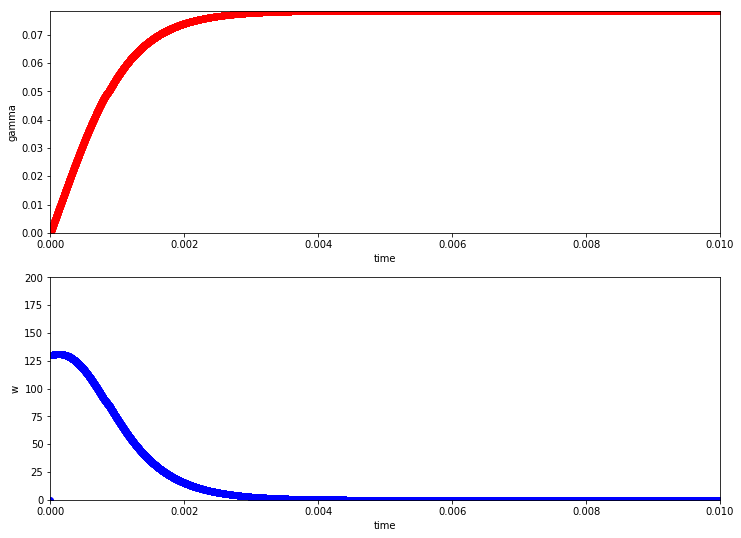

In [197]:
"""Plot solution"""
fig3 = plt.figure(figsize=(12, 9))
cx1 = fig3.add_subplot(211)
cx1.set_xlabel('time')
cx1.set_ylabel('gamma')
cx1.set_ylim( 0 , step )
cx1.set_xlim( 0 , t_array[keep_i-1] )
cx2 = fig3.add_subplot(212)
cx2.set_xlabel('time')
cx2.set_ylabel('w')
cx2.set_ylim( 0 , 200 )
cx2.set_xlim( 0 , t_array[keep_i-1] )
for i in np.arange( 0, len(snipped_sol) ):
    cx1.scatter( t_array[i], snipped_sol[i][0], color='r' )
    cx2.scatter( t_array[i], snipped_sol[i][1], color='b' )
plt.show()